In [602]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random
import re
import numpy as np
from sklearn.metrics import r2_score

## pre process

In [603]:
CAR_PATH = "D:\Divar-Scraping\info\main_info.csv"
dataset = pd.read_csv(CAR_PATH)

In [604]:
dataset.shape

(258650, 11)

In [605]:
from collections import Counter
Counter(dataset['Age'])

Counter({0: 38352,
         1: 16702,
         12: 13703,
         6: 13150,
         7: 12041,
         5: 11724,
         13: 11556,
         2: 11240,
         14: 11123,
         9: 10590,
         15: 10220,
         8: 9561,
         16: 9368,
         17: 9224,
         4: 8841,
         19: 8737,
         3: 8530,
         18: 8334,
         11: 8330,
         10: 6441,
         20: 6438,
         21: 4378,
         22: 2859,
         23: 1690,
         24: 1120,
         25: 978,
         26: 720,
         30: 485,
         27: 474,
         31: 454,
         29: 365,
         28: 324,
         32: 213,
         33: 119,
         35: 114,
         36: 106,
         34: 46})

In [606]:
dataset.head(10)

,MotorState,ChassisState,BodyState,Insurance,Gearbox,Price,Usage,Age,Color,FuelType,BrandType
0,سالم,NaN,خط و خش جزیی,8.0,دنده ای,142000000,350000,12,سفید,بنزینی,پراید 131 SL
1,سالم,NaN,خط و خش جزیی,6.0,دنده ای,124000000,247000,18,مشکی,دوگانه سوز شرکتی,پراید صندوق‌دار CNG
2,سالم,NaN,خط و خش جزیی,2.0,دنده ای,133000000,500000,15,طوسی,دوگانه سوز شرکتی,پراید صندوق‌دار بنزینی
3,سالم,سالم و پلمپ,خط و خش جزیی,9.0,دنده ای,365000000,330000,12,نقره‌ای,بنزینی,پراید اتوماتیک
4,NaN,سالم و پلمپ,سالم و بی‌خط و خش,NaN,NaN,442380000,0,0,سفید,بنزینی,ساینا دنده‌ای S
5,NaN,NaN,سالم و بی‌خط و خش,NaN,NaN,457000000,0,0,سفید,بنزینی,پژو پارس ساده
6,سالم,NaN,سالم و بی‌خط و خش,6.0,دنده ای,280000000,69000,3,سفید,بنزینی,تیبا 2 (هاچبک) EX
7,سالم,سالم و پلمپ,خط و خش جزیی,5.0,دنده ای,11000000,123204,21,سفید,بنزینی,پراید صندوق‌دار بنزینی
8,سالم,سالم و پلمپ,سالم و بی‌خط و خش,12.0,دنده ای,588000000,0,0,سفید,بنزینی,پژو پارس موتور جدید XU7P
9,سالم,سالم و پلمپ,سالم و بی‌خط و خش,5.0,دنده ای,385000000,65000,4,نوک‌مدادی,بنزینی,پژو 405 GLX بنزینی


In [607]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258650 entries, 0 to 258649
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   MotorState    245839 non-null  object 
 1   ChassisState  219819 non-null  object 
 2   BodyState     258412 non-null  object 
 3   Insurance     234872 non-null  float64
 4   Gearbox       237184 non-null  object 
 5   Price         258650 non-null  int64  
 6   Usage         258650 non-null  int64  
 7   Age           258650 non-null  int64  
 8   Color         258650 non-null  object 
 9   FuelType      210001 non-null  object 
 10  BrandType     258650 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 21.7+ MB


In [608]:
dataset.dtypes

MotorState       object
ChassisState     object
BodyState        object
Insurance       float64
Gearbox          object
Price             int64
Usage             int64
Age               int64
Color            object
FuelType         object
BrandType        object
dtype: object

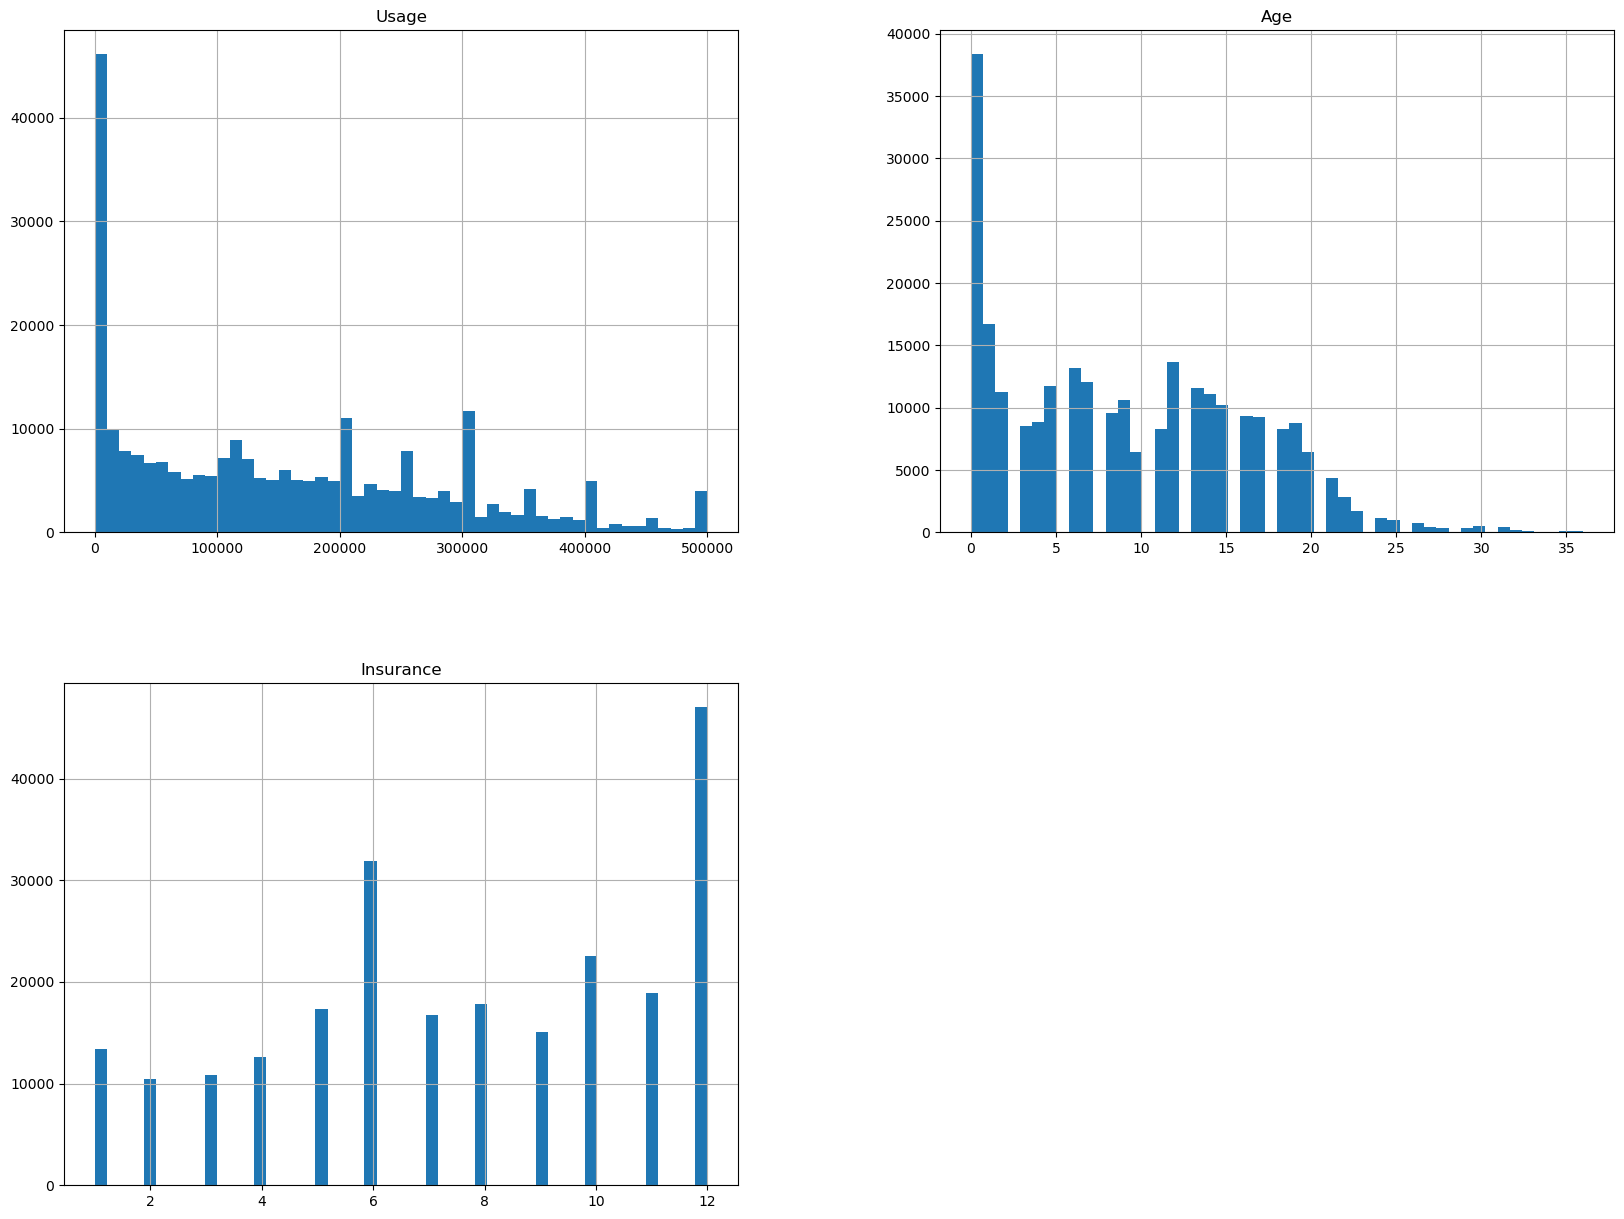

In [609]:
dataset[["Usage", "Age", "Insurance"]].hist(bins=50, figsize=(20,15))
plt.show()

### delete outliers

In [610]:
len(dataset[dataset["Price"] <= 30_000_000])

5326

In [611]:
len(dataset[dataset["Price"] >= 5_000_000_000])

1760

In [612]:
dataset = dataset[dataset["Price"] > 30_000_000]
dataset = dataset[dataset["Price"] <= 5_000_000_000]

### delete bad data

In [613]:
len(dataset[dataset["Price"] == 111_111_111])

5266

In [614]:
# Pattern to match sequences of at least 4 identical digits
pattern_same_digit = r'(\d)\1{3,}'

# Pattern to exclude any sequences of zeros
pattern_exclude_zeros = r'(?!0+)'

# Combine the patterns with logical AND
regex = rf'\b{pattern_same_digit}(?={pattern_exclude_zeros})\d+\b'

matching_indices = dataset[dataset['Price'].astype(str).str.contains(regex)].index

dataset = dataset.drop(matching_indices)

C:\Users\mosta\AppData\Local\Temp\ipykernel_8972\991693960.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_indices = dataset[dataset['Price'].astype(str).str.contains(regex)].index


In [615]:
price_values_to_delete = [123_456_789, 987_654_321, 87_654_321, 234_567_891, 345_678_910]
mask = dataset['Price'].isin(price_values_to_delete)
len(dataset[mask])

260

In [616]:
dataset = dataset[~mask]

In [617]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242829 entries, 0 to 258649
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   MotorState    231680 non-null  object 
 1   ChassisState  206186 non-null  object 
 2   BodyState     242609 non-null  object 
 3   Insurance     221985 non-null  float64
 4   Gearbox       223642 non-null  object 
 5   Price         242829 non-null  int64  
 6   Usage         242829 non-null  int64  
 7   Age           242829 non-null  int64  
 8   Color         242829 non-null  object 
 9   FuelType      201533 non-null  object 
 10  BrandType     242829 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 22.2+ MB


In [618]:
dataset["Gearbox"]      = dataset["Gearbox"].replace({'اتوماتیک': 1, 'دنده ای': 0})
dataset["MotorState"]   = dataset["MotorState"].replace({'سالم': 0, 'نیاز به تعمیر': 1, "تعویض شده": 2})
dataset["ChassisState"] = dataset["ChassisState"].replace({'سالم و پلمپ': 0, 'ضربه خورده': 1, "رنگ شده": 2,})
dataset["FuelType"]    = dataset["FuelType"].replace({'بنزینی': "gasoline",
                                                        'دوگانه سوز دستی': 'dual_manual',
                                                         "دوگانه سوز شرکتی": 'dual_company',
                                                           "گازوئیل": 'diesel',
                                                          })

In [619]:
fill_mode_features = ["BodyState", "ChassisState", "MotorState", "Gearbox", "FuelType"]

for column in fill_mode_features:
    mode_value = dataset[column].mode().iloc[0]
    dataset[column].fillna(mode_value, inplace=True)
    
dataset["Insurance"].fillna(0, inplace=True) 

In [620]:
corr_matrix = dataset[["Insurance", "Usage", "Age", "Price", "ChassisState", "MotorState", "Gearbox"]].corr()
corr_matrix["Price"].sort_values(ascending=False)

Price           1.000000
Gearbox         0.646560
Insurance       0.075328
MotorState     -0.052437
ChassisState   -0.061758
Usage          -0.349452
Age            -0.388567
Name: Price, dtype: float64

In [621]:
dataset["BrandType"].value_counts()

BrandType
پراید صندوق‌دار بنزینی           12794
پژو 206 تیپ ۲                     9541
پراید صندوق‌دار CNG               7140
پراید 131 SE                      6730
پژو 405 GLX بنزینی                6284
                                 ...  
میتسوبیشی لنسر دنده ای 1600cc        1
لکسوس GS 250                         1
سوزوکی کیزاشی دنده‌ای                1
بی ام و سری 2 اکتیوتور 218i          1
اپل آسترا استیشن                     1
Name: count, Length: 1116, dtype: int64

In [622]:
data = dataset[["FuelType"]]

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(data)
one_hot_array = housing_cat_1hot.toarray()
dataset.drop(columns=["FuelType"], inplace=True)
dataset[cat_encoder.get_feature_names_out(["FuelType"])] = one_hot_array  

In [623]:
dataset = dataset.drop(columns=["Color"])
# TODO: delete below line and embed when model got bigger
dataset = dataset.drop(columns=["BodyState"])

In [624]:
brand_type_counts = dataset["BrandType"].value_counts()
categories_to_drop = brand_type_counts[brand_type_counts <= 2000].index

# Drop rows where the "BrandType" column has values from categories_to_drop
dataset = dataset[~dataset["BrandType"].isin(categories_to_drop)]

dataset.reset_index(drop=True, inplace=True)

In [625]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset[['Usage']] = \
                scaler.fit_transform(dataset[['Usage']])
dataset[['Age']] = \
                scaler.fit_transform(dataset[['Age']])
dataset[['Insurance']] = \
                scaler.fit_transform(dataset[['Insurance']])

In [626]:
dataset.loc[dataset['BrandType'] == 'پراید صندوق\u200cدار CNG', 'BrandType']  = "پراید صندوق دار"
dataset.loc[dataset['BrandType'] == 'پراید صندوق\u200cدار بنزینی', 'BrandType'] = "پراید صندوق دار"
dataset.loc[dataset['BrandType'] == 'پراید صندوق\u200cدار LPG', 'BrandType']  = "پراید صندوق دار"
dataset.loc[dataset['BrandType'] == 'پراید صندوق دار بنزینی', 'BrandType']      = "پراید صندوق دار"
dataset.loc[dataset['BrandType'] == 'پراید صندوق دار CNG', 'BrandType']       = "پراید صندوق دار"

dataset.loc[dataset['BrandType'] == 'پراید 141 دوگانه سوز', 'BrandType']       = "پراید 141 SX"
dataset.loc[dataset['BrandType'] == 'پراید 141 ساده', 'BrandType']            = "پراید 141 SX"

dataset.loc[dataset['BrandType'] == 'وانت پراید 151 دوگانه سوز', 'BrandType']    = "وانت پراید 151 SE"
dataset.loc[dataset['BrandType'] == 'وانت پراید 151 پلاس', 'BrandType']        = "وانت پراید 151 SE"

dataset.loc[dataset['BrandType'] == 'سمند X7 دوگانه سوز', 'BrandType']        = "سمند X7"
dataset.loc[dataset['BrandType'] == 'سمند X7 بنزینی', 'BrandType']           = "سمند X7"

dataset.loc[dataset['BrandType'] == 'تیبا صندوق\u200cدار EX دوگانه سوز', 'BrandType']   = "تیبا صندوق\u200cدار EX"
dataset.loc[dataset['BrandType'] == 'تیبا صندوق\u200cدار EX دوگانه سوز', 'BrandType']   = "تیبا صندوق\u200cدار SX"
dataset.loc[dataset['BrandType'] == 'تیبا صندوق\u200cدار SX دوگانه سوز', 'BrandType']   = "تیبا صندوق دار SX"

dataset.loc[dataset['BrandType'] == 'پژو 405 GLX - دوگانه سوز LPG', 'BrandType']   = "پژو 405 GLX"
dataset.loc[dataset['BrandType'] == 'پژو 405 GLX - دوگانه سوز CNG', 'BrandType']   = "پژو 405 GLX"
dataset.loc[dataset['BrandType'] == 'پژو 405 GLX بنزینی', 'BrandType']             = "پژو 405 GLX"
dataset.loc[dataset['BrandType'] == 'پژو 405 جی ال ایکس (GLX)', 'BrandType']      = "پژو 405 GLX"

dataset.loc[dataset['BrandType'] == 'پژو 405 بنزینی GLX - TU5', 'BrandType']      = "پژو 405 GLX - TU5"
dataset.loc[dataset['BrandType'] == 'پژو 405 دوگانه سوز GLX - TU5', 'BrandType']      = "پژو 405 GLX - TU5"

In [627]:
len(dataset["BrandType"].unique())

27

In [628]:
u = dataset['BrandType'].unique()
values_containing_value = [value for value in u if "دوگانه" in value]
values_containing_value, len(values_containing_value)

(['پژو پارس دوگانه سوز', 'پراید 131 دوگانه سوز'], 2)

In [629]:
len(dataset[dataset["BrandType"] == "پژو 405 GLX - TU5"])

0

In [630]:
dataset["BrandType"].value_counts()[:10]

BrandType
پراید صندوق دار    19934
پژو 405 GLX        13745
پژو 206 تیپ ۲       9541
پراید 131 SE        6730
پژو پارس سال        6047
پژو پارس LX TU5     5210
سمند LX ساده        5000
پیکان وانت CNG      3930
پژو پارس ساده       3763
پژو 206 تیپ ۵       3185
Name: count, dtype: int64

In [631]:
brand_to_index = {brand: i for i, brand in enumerate(dataset['BrandType'].unique())}
index_to_brand = {index: brand for index, brand in enumerate(dataset['BrandType'].unique())}

dataset['BrandType'] = dataset['BrandType'].map(brand_to_index)

In [632]:
# body_to_index = {body: i for i, body in enumerate(dataset['BodyState'].unique())}
# index_to_body = {index: body for index, body in enumerate(dataset['BodyState'].unique())}

# dataset['BodyState'] = dataset['BodyState'].map(body_to_index)

In [633]:
dataset['BrandType'].value_counts()[:10]

BrandType
0     19934
5     13745
7      9541
10     6730
20     6047
6      5210
23     5000
24     3930
2      3763
22     3185
Name: count, dtype: int64

In [634]:
dataset.columns

Index(['MotorState', 'ChassisState', 'Insurance', 'Gearbox', 'Price', 'Usage',
       'Age', 'BrandType', 'FuelType_diesel', 'FuelType_dual_company',
       'FuelType_dual_manual', 'FuelType_gasoline'],
      dtype='object')

In [635]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_val_index in split.split(dataset, dataset["Gearbox"]):
    test_val_set   = dataset.loc[test_val_index]
    train_set      = dataset.loc[train_index]

test_val_set.reset_index(drop=True, inplace=True)
# Now, split the train_val_set into train and validation sets
split_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # 50% validation, 50% train

for test_index, val_index in split_test.split(test_val_set, test_val_set["Gearbox"]):
    test_set  = test_val_set.loc[test_index]
    val_set   = test_val_set.loc[val_index]
    
train_set.shape, test_set.shape, val_set.shape

((106428, 12), (5913, 12), (5913, 12))

In [636]:
dtype = torch.float

Ytr   = torch.tensor(train_set["Price"].values, dtype = dtype)
Yval  = torch.tensor(val_set["Price"].values, dtype = dtype)
Ytest = torch.tensor(test_set["Price"].values, dtype = dtype)

train_set = train_set.drop(["Price"], axis=1)
val_set   = val_set.drop(["Price"], axis=1)
test_set  = test_set.drop(["Price"], axis=1)

Xtr   = torch.tensor(train_set.values, dtype = dtype)
Xval  = torch.tensor(val_set.values,   dtype = dtype)
Xtest = torch.tensor(test_set.values,  dtype = dtype)

In [637]:
torch.manual_seed(42)
random.seed(42)

In [638]:
Ytr_scale = \
scaler.fit_transform(Ytr.reshape(-1, 1))
Ytr_scale = torch.tensor(Ytr_scale,  dtype = dtype)

Yval_scale = \
scaler.fit_transform(Yval.reshape(-1, 1))
Yval_scale = torch.tensor(Yval_scale,  dtype = dtype)

Ytest_scale = \
scaler.fit_transform(Ytest.reshape(-1, 1))
Ytest_scale = torch.tensor(Ytest_scale,  dtype = dtype)

In [639]:
Xtr.shape, Ytr_scale.shape

(torch.Size([106428, 11]), torch.Size([106428, 1]))

In [640]:
inp = Xtr.shape[1] - 1
out = 1
hid = 100

loss_fn = torch.nn.MSELoss()
learning_rate = 0.00001

In [641]:
Xtr.shape[1]

11

In [642]:
embedding_brand_dim = 10

NN = nn.Sequential(
    nn.Linear(inp + embedding_brand_dim, hid),
    nn.BatchNorm1d(hid),
    nn.Sigmoid(),
    
    nn.Linear(hid, hid),
    nn.BatchNorm1d(hid),
    nn.Sigmoid(),
    
    nn.Linear(hid, hid),
    nn.BatchNorm1d(hid),
    nn.Sigmoid(),
    
    nn.Linear(hid, hid),
    nn.BatchNorm1d(hid),
    nn.Sigmoid(),
    
    nn.Linear(hid, out)
)

In [643]:
num_brands = dataset['BrandType'].nunique()
brand_type_embedding = nn.Embedding(num_brands, embedding_brand_dim)

class CustomModel(nn.Module):
    def __init__(self, brand_embedding, model, brand_type_col_index):
        super(CustomModel, self).__init__()
        self.brand_embedding = brand_embedding
        self.model = model
        self.brand_type_col_index = brand_type_col_index
        
    def forward(self, x):
        if x.ndim == 1:
            brand_type = x[brand_type_col_index].long()
            x = np.delete(x, brand_type_col_index)
        else:
            brand_type = x[:, brand_type_col_index].long()
            x_b = x[:, :self.brand_type_col_index]
            x = torch.cat([x_b, x[:, self.brand_type_col_index + 1:]], dim=1)
        
        brand_embedded = self.brand_embedding(brand_type)
        
        if x.ndim == 1:
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
            x = torch.cat([x, brand_embedded.unsqueeze(0)], dim=1)
        else:
            x = torch.cat([x, brand_embedded], dim=1)
            
        predicted = self.model(x)
        return predicted

brand_type_col_index = dataset.columns.get_loc('BrandType') - 1
model = CustomModel(brand_type_embedding, NN, brand_type_col_index)

In [644]:
batch_size = 64
losses = []

for iter in range(200000):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr_scale[ix] # batch X,Y

    y_pred = model(Xb)
    loss = loss_fn(y_pred, Yb.view(-1, 1))

    if iter % 10000 == 0:
        print(iter, loss.item())
#         learning_rate = learning_rate /  10

    losses.append(loss.log10().item())
#     if iter % 50000 and iter != 0:
#         learning_rate = learning_rate /  10
    
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

0 0.14316223561763763
10000 0.00969753134995699
20000 0.010707885026931763
30000 0.004526067059487104
40000 0.008092831820249557
50000 0.01188572496175766
60000 0.024108918383717537
70000 0.0024993703700602055
80000 0.006313767749816179
90000 0.001996759558096528
100000 0.004594485275447369
110000 0.004431284032762051
120000 0.0028875654097646475
130000 0.007297467906028032
140000 0.004081323742866516
150000 0.003191809169948101
160000 0.0026926894206553698
170000 0.0022608954459428787
180000 0.0046745408326387405
190000 0.003504425287246704


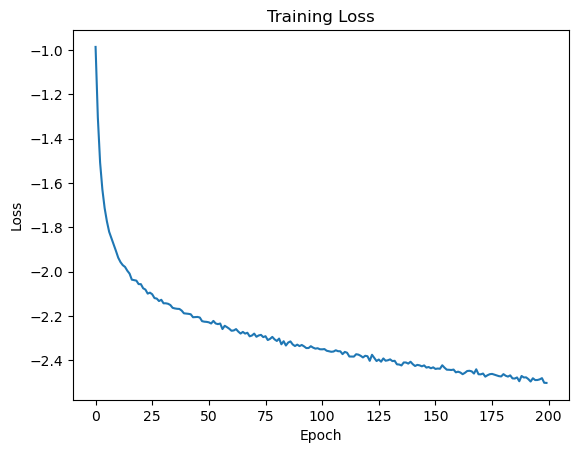

In [645]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [646]:
model.eval()
torch.no_grad() 

In [647]:
batch_size = 64

for iter in range(100000):
    ix = torch.randint(0, Xval.shape[0], (batch_size,))
    Xb, Yb = Xval[ix], Yval_scale[ix]  # batch X,Y

    y_pred = model(Xb)
    loss = loss_fn(y_pred, Yb.view(-1, 1))

    if iter % 10000 == 0:
        print(iter, loss.item())

0 0.00072937534423545
10000 0.0017925224965438247
20000 0.002014974830672145
30000 0.0008071038173511624
40000 0.0007986074779182673
50000 0.001780722290277481
60000 0.0007465389790013433
70000 0.0008893876802176237
80000 0.0037856874987483025
90000 0.0006346766604110599


In [648]:
y_pred_r2 = model(Xval)
r2 = r2_score(Yval_scale, y_pred_r2.detach().numpy().reshape(-1, 1))
print("R2 Score: ", r2)

R2 Score:  0.06133216262472885


In [552]:
with torch.no_grad():
    model.eval()
    output = model(Xtr[2])
    print(output)

tensor([[0.0000, 0.0000, 0.0833, 0.0000, 0.3000, 0.1944, 0.0000, 0.0000, 0.0000,
         1.0000]]) tensor([[ 0.7583, -2.8873, -0.6902, -0.6523,  0.3949,  0.4717, -0.8254,  0.9967,
          0.7904, -0.4139]])
tensor([[-0.2515]])


C:\Users\mosta\AppData\Local\Temp\ipykernel_8972\659157625.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)


In [ ]:
sample_test_index = 32
sample_row = Xtest[sample_test_index]  # No need for unsqueeze(0) here

brand_type = sample_row[brand_type_col_index]
brand_type = torch.tensor(brand_type, dtype=torch.long).unsqueeze(0)

print(sample_row, brand_type)

# Forward pass through the model
y_pred = model(sample_row, brand_type)

predicted_price = scaler.inverse_transform(np.array([y_pred.item()]).reshape(-1, 1)).item()
inverted_price  = scaler.inverse_transform(np.array(Ytest_scale[sample_test_index].item()).reshape(-1, 1))
actual_price    = Ytest[sample_test_index].item()

print("Predicted price of automobile is : ", predicted_price)
print("Actual price of automobile is : ", int(inverted_price))
print("Actual price of automobile is : ", int(actual_price))

# Compute the percentage error
percentage_error = abs(actual_price - predicted_price) / actual_price * 100

# Calculate the accuracy
accuracy = 100 - percentage_error
print("Accuracy:", accuracy)

brand_index = test_set.iloc[34]['BrandType']
brand_name = index_to_brand[brand_index]
print(brand_name)